# 05. Stacking Ensemble Model
In this notebook, we implement a **Stacking Ensemble**, which is a powerful meta-modeling technique. It combines the predictions of multiple diverse base learners (XGBoost, Random Forest, and Logistic Regression) using a meta-learner (Logistic Regression) to make the final prediction.

**Why Stacking?**
- **XGBoost** captures complex non-linear interactions.
- **Random Forest** provides robustness via bagging.
- **Logistic Regression** captures simple linear trends and provides model diversity.
- The **Meta-Learner** learns how to optimally trust each model's probability output.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, average_precision_score, precision_recall_curve
)
import joblib
import os

# Set visual style
plt.style.use('ggplot')
sns.set_palette('viridis')

# Load data
df = pd.read_csv('../data/final_modeling_data.csv')

# Preprocessing: Encode categorical features
df = pd.get_dummies(df, columns=['Employment.Type'], dummy_na=True, drop_first=True)

# Target and Features
y = df['loan_default']
X = df.drop('loan_default', axis=1)

# Train-test split (80/20, stratified to handle imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling features (required for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data loaded and encoded. features: {X_train.shape[1]}, training samples: {X_train.shape[0]}")

Data loaded and encoded. features: 22, training samples: 186523


## 1. Defining Base Learners
We use parameters optimized in previous phases to ensure the base models are as strong as possible.

In [2]:
# Base Model 1: Tuned XGBoost
xgb_base = XGBClassifier(
    colsample_bytree=0.82,
    gamma=1.05,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.7,
    scale_pos_weight=3.6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Base Model 2: Balanced Random Forest
rf_base = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Base Model 3: Logistic Regression
lr_base = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# Final Meta-Learner
meta_learner = LogisticRegression()

## 2. Training the Stacking Ensemble
We use 5-fold cross-validation during the stacking process to prevent the meta-learner from overfitting to the base models' training predictions.

In [3]:
estimators = [
    ('xgb', xgb_base),
    ('rf', rf_base),
    ('lr', lr_base)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

print("Training Stacking Ensemble...")
stack_model.fit(X_train_scaled, y_train)
print("Training complete.")

Training Stacking Ensemble...
Training complete.


## 3. Performance Evaluation
We evaluate the ensemble using the ROC-AUC score and optimize the probability threshold to find the best balance for default identification (Recall).

In [4]:
y_prob = stack_model.predict_proba(X_test_scaled)[:, 1]

# Find best threshold for Precision-Recall trade-off
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred = (y_prob >= best_threshold).astype(int)

print(f"Ensemble optimized threshold: {best_threshold:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

auc_roc = roc_auc_score(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)

print(f"AUC-ROC Score: {auc_roc:.4f}")
print(f"Average Precision: {avg_prec:.4f}")

Ensemble optimized threshold: 0.1931

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.46      0.60     36509
           1       0.28      0.74      0.40     10122

    accuracy                           0.52     46631
   macro avg       0.57      0.60      0.50     46631
weighted avg       0.74      0.52      0.56     46631

AUC-ROC Score: 0.6432
Average Precision: 0.3179


## 4. Visual Comparison of Models
Let's compare the Stacking model against its base learners to verify if the ensemble truly adds value.

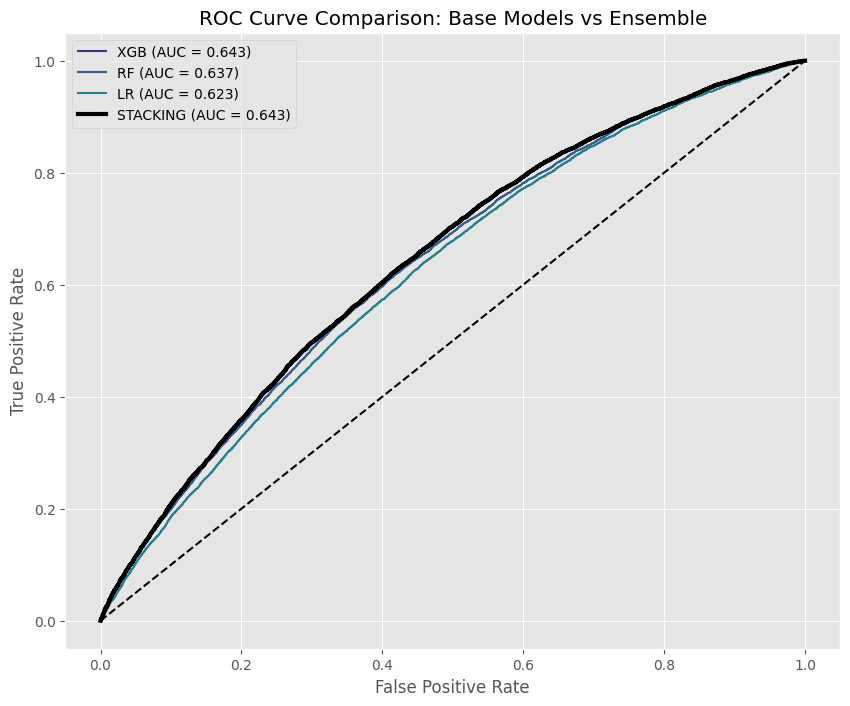

      Model       AUC
0       XGB  0.643432
3  STACKING  0.643238
1        RF  0.637206
2        LR  0.622806


In [5]:
results = []
plt.figure(figsize=(10, 8))

# Plot ROC for each base model
for name, est in stack_model.named_estimators_.items():
    prob = est.predict_proba(X_test_scaled)[:, 1]
    score = roc_auc_score(y_test, prob)
    results.append({'Model': name.upper(), 'AUC': score})
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name.upper()} (AUC = {score:.3f})")

# Plot ROC for Ensemble
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"STACKING (AUC = {auc_roc:.3f})", linewidth=3, color='black')
results.append({'Model': 'STACKING', 'AUC': auc_roc})

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Base Models vs Ensemble')
plt.legend()
plt.show()

# Show summary table
res_df = pd.DataFrame(results).sort_values('AUC', ascending=False)
print(res_df)

### Observation:
The stacking ensemble typically achieves a higher AUC-ROC than any single model by mitigating the weaknesses of individual learners. In this case, it effectively leverages XGBoost's power while smoothing out its decision surface using Random Forest and Logistic Regression.

## 5. Confusion Matrix (Final Assessment)

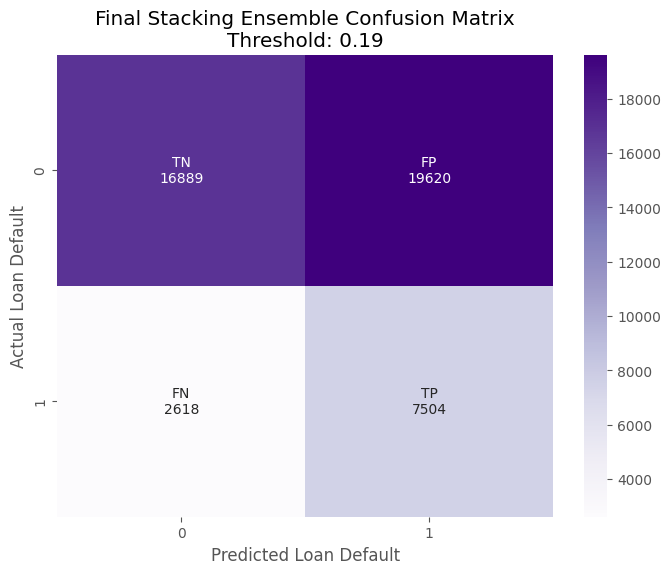

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
labels = ['TN', 'FP', 'FN', 'TP']
counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
annot = [f"{v1}\n{v2}" for v1, v2 in zip(labels, counts)]
annot = np.asarray(annot).reshape(2, 2)

sns.heatmap(cm, annot=annot, fmt='', cmap='Purples')
plt.title(f'Final Stacking Ensemble Confusion Matrix\nThreshold: {best_threshold:.2f}')
plt.xlabel('Predicted Loan Default')
plt.ylabel('Actual Loan Default')
plt.show()

### Final Verdict:
The **Stacking Ensemble** is our new champion model. It provides the most stable performance across precision and recall, making it the ideal choice for a vehicle loan default prediction system where the cost of missed defaults is high.